# Data Question 3

## Exploring earthquake data

Nate Silver discusses the difficulty of predicting earthquakes in The Signal and the Noise, <br>but are there factors that make an earthquake more likely? <br>
Are there factors that make an earthquake more deadly? <br>
Where would you live if you wanted to eliminate the risk of experiencing an earthquake? <br>
Where would you avoid living?

## Data cleaning tasks include:
1. Replace empty strings with NaN
2. Remove the footnotes from the 'Other Source Deaths' column
3. Convert Magnitude to a numeric
4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
5. Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

In [78]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import numpy as np
import re
import requests
import folium
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

%matplotlib inline
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

In [3]:
# URL for Wikipedia article with earthquake data table
url = 'http://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'

In [4]:
# create a Request object for the wikipedia page for the Turing Award
response = requests.get(url)

# read the resulting HTML into a variable called result_text
result_text = response.text

In [5]:
# create the soup by constructing a BS object from the html page and the appropriate parser
soup = BS(result_text, 'html.parser')
#soup

In [6]:
# Find table from web page
# There is only one table on the wikipedia page
table = soup.find_all('table', attrs = {'class':'sortable wikitable'})
#table

In [7]:
table;

In [8]:
table_rows = table[0].findAll('tr')
table_rows;

In [9]:
data = []
for ind, tr in enumerate(table_rows):
    tag = 'td' if ind else 'th'
    row = [elem.text for elem in tr.findAll(tag)]
    data.append(row)
earthquakes_df = pd.DataFrame(data[1:], columns=data[0])
earthquakes_df.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,\n
1,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,\n
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,\n
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,\n
4,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,\n


### Secondary effects are reported, they are indicated by “T”, “L”, “F” or “Lq”
T = Tsunami,
L = Landslide,
F = Fire,
Lq = Liquefaction

PDE Totals are reported by United States Geological Survey’s Preliminary Determination of Epicenters <br>

<strong>pde_shaking</strong> = Deaths from shaking only <br>

<strong>pde_total</strong> = total fatalities resulting from earthquake shaking and secondary effects, such as tsunami, landslide, fire, liquefaction or other factors (e.g., heart failure) <br>

<strong>utsu_total</strong> = the total deaths resulting from an earthquake (up to date up to 2003) <br>

<strong>em_dat_total</strong> = records from the Emergency Events Database (Earthquake source parameters in the EM-DAT are often absent, incomplete, or erroneous. Consequently, several events may be missed in the automated catalog associations. Furthermore, where the impact of an earthquake spans political boundaries, database entries are often subdivided by country. For significant events, the observed fatalities are aggregated and manually associated.) <br>

<strong>other_source</strong> = other sources of shaking deaths and indicates improved fatality estimates from official reports and detailed scholarly studies, where available

## 1. Replace empty strings with NaN

In [10]:
# Replacing end lines with blank space
earthquakes_df = earthquakes_df.replace('\n', '')
# Replacing empty values with NaN
earthquakes_df = earthquakes_df.replace("", np.nan)
earthquakes_df.head(5)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4,NaN,NaN


In [11]:
# Creating new DF for the clean data
# Changing columns to make them easier to call
clean_df = earthquakes_df
clean_df.columns = ['origin', 'country', 'lat', 'long', 'depth_km', 'magnitude', 'secondary_effects', 
                 'pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total', 'other_source']

clean_df.head()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4,NaN,NaN


In [12]:
clean_df.tail()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894[20]\n
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150+\n
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111+\n
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,"601 (as of October 30, 2011)\n"


In [13]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
origin               1340 non-null object
country              1340 non-null object
lat                  1326 non-null object
long                 1326 non-null object
depth_km             1250 non-null object
magnitude            1339 non-null object
secondary_effects    373 non-null object
pde_shaking          739 non-null object
pde_total            750 non-null object
utsu_total           1027 non-null object
em_dat_total         560 non-null object
other_source         37 non-null object
dtypes: object(12)
memory usage: 125.7+ KB


In [14]:
#clean_df.loc[:,['secondary_effects', 'pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total', 'other_source']] = clean_df.loc[:,['secondary_effects', 'pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total', 'other_source']].fillna(0)
clean_df.tail()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894[20]\n
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150+\n
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111+\n
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,"601 (as of October 30, 2011)\n"


In [15]:
# Cleaning up other_source column
# Removing \n
# removing footnotes
# removing +
# removing parentheses
clean_df.loc[clean_df['other_source'].str.contains('\n').fillna(False),'other_source']= clean_df[clean_df['other_source'].str.contains('\n').fillna(False)].loc[:,'other_source'].str[:-1] #= clean_df['other_source'].str[:-2]
clean_df.tail()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894[20]
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150+
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111+
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,"601 (as of October 30, 2011)"


# 2. Remove the footnotes from the 'Other Source Deaths' column


In [16]:
for row in range(clean_df.shape[0]):
    df_str = clean_df.loc[row, 'other_source']
    if type(df_str) == str:
        if df_str.isdigit() == True:
            clean_df.loc[row, 'other_source'] = df_str
        else:
            count = 0
            while df_str[count].isdigit() or df_str[count] == ',':
                count+=1
                if count == len(df_str):
                    break
            df_str = df_str[:count]
            clean_df.loc[row, 'other_source'] = df_str
        
clean_df.tail(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
1330,2010-03-08 02:32,Turkey (see 2010 Elâzığ earthquake),NaN,NaN,NaN,6.1 Mw,NaN,NaN,NaN,NaN,NaN,42
1331,2010-03-11 14:39,Chile (see 2010 Pichilemu earthquake),NaN,NaN,NaN,6.9 Mw,L,NaN,NaN,NaN,NaN,1
1332,2010-04-14 23:49,China (see 2010 Yushu earthquake),NaN,NaN,NaN,6.9 Mw,L,NaN,NaN,NaN,NaN,"2,698"
1333,2011-02-21 23:51,New Zealand (see 2011 Christchurch earthquake),NaN,NaN,NaN,6.3 Mw,Lq,NaN,NaN,NaN,NaN,181
1334,2011-03-10 04:58,China (see 2011 Yunnan earthquake),NaN,NaN,NaN,5.4 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1335,2011-03-11 14:46,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894
1336,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150
1337,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111
1339,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,601


In [17]:
clean_df['other_source'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '231000', '41', '60', '215', '34', '295', '79', '189',
       '1,115', '222,517', '521', '42', '2,698', '181', '15894', '150',
       '111', '601'], dtype=object)

In [18]:
clean_df['other_source'].replace(regex=True,inplace=True,to_replace=r'\,', value='')
clean_df['other_source'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '231000', '41', '60', '215', '34', '295', '79', '189',
       '1115', '222517', '521', '42', '2698', '181', '15894', '150',
       '111', '601'], dtype=object)

## 3. Convert Magnitude to a numeric


In [19]:
clean_df.magnitude = clean_df.magnitude.str.replace('5 ML', '5.0 ML') #correction for non-decimal entry
clean_df.magnitude = clean_df.magnitude.str.extract('(\d+\.\d+)')
clean_df['magnitude'] = pd.to_numeric(clean_df.magnitude)
clean_df['magnitude'].unique()

array([7. , 5.9, 7.7, 6.5, 6.4, 7.2, 6.8, 6.9, 5.5, 7.5, 6.7, 6. , 5.7,
       5.8, 8.3, 6.2, 6.3, 7.8, 6.6, 8.8, 7.1, 8.2, 7.9, 7.3, 7.6, 8.1,
       4.9, 7.4, 8.6, nan, 8.7, 8.5, 5.3, 5. , 5.4, 5.6, 6.1, 8.4, 4.8,
       8. , 9. , 9.5, 9.2, 5.2, 5.1, 4.3, 4.6, 4.2, 4.5, 4.7, 4.4, 3.5,
       2.3, 3.4, 2.8, 2. , 2.6, 3.8, 4. , 2.7, 9.1, 2.2])

In [20]:
# Looking at entry with ? in some of the columns
clean_df.iloc[413,:]

origin                                     1963-06-26 04:17
country              Macedonia (see 1963 Skopje earthquake)
lat                                                       ?
long                                                     ??
depth_km                                                  ?
magnitude                                               6.1
secondary_effects                                       NaN
pde_shaking                                             NaN
pde_total                                              1100
utsu_total                                              NaN
em_dat_total                                            NaN
other_source                                           None
Name: 413, dtype: object

In [21]:
# Fixing bad entry that previously had ?
clean_df.iloc[413,2:5] = np.nan
clean_df.iloc[413,:]

origin                                     1963-06-26 04:17
country              Macedonia (see 1963 Skopje earthquake)
lat                                                     NaN
long                                                    NaN
depth_km                                                NaN
magnitude                                               6.1
secondary_effects                                       NaN
pde_shaking                                             NaN
pde_total                                              1100
utsu_total                                              NaN
em_dat_total                                            NaN
other_source                                           None
Name: 413, dtype: object

In [22]:
# Fill death columns with 0 instead of NaN
# clean_df[['pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total']] = clean_df[['pde_shaking', 'pde_total', 'utsu_total', 'em_dat_total']].fillna(value=0)


In [23]:
# Converting relevant columns to numeric
clean_df['pde_shaking'] = pd.to_numeric(clean_df['pde_shaking'])
clean_df['pde_total'] = pd.to_numeric(clean_df['pde_total'])
clean_df['utsu_total'] = pd.to_numeric(clean_df['utsu_total'])
clean_df.em_dat_total = clean_df.em_dat_total.str.extract('(\d+)')
clean_df['em_dat_total'] = pd.to_numeric(clean_df['em_dat_total'])
clean_df['lat'] = pd.to_numeric(clean_df['lat'])
clean_df['long'] = pd.to_numeric(clean_df['long'])
clean_df['other_source'] = pd.to_numeric(clean_df['other_source'])

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
origin               1340 non-null object
country              1340 non-null object
lat                  1325 non-null float64
long                 1325 non-null float64
depth_km             1249 non-null object
magnitude            1339 non-null float64
secondary_effects    373 non-null object
pde_shaking          739 non-null float64
pde_total            750 non-null float64
utsu_total           1027 non-null float64
em_dat_total         560 non-null float64
other_source         37 non-null float64
dtypes: float64(8), object(4)
memory usage: 125.7+ KB


In [24]:
clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source
0,1900-05-11 17:23,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN
5,1901-08-09 09:23,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN
7,1902-01-30 14:01,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN
8,1902-02-13 09:39,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN
9,1902-03-09 07:46,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN


## 4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.

In [25]:
# New column with highest value from all the death columns
clean_df['deaths'] = clean_df[['pde_total','utsu_total','em_dat_total', 'other_source']].max(axis=1)

clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths
0,1900-05-11 17:23,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
2,1900-10-29 09:11,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0
5,1901-08-09 09:23,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0
7,1902-01-30 14:01,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0
8,1902-02-13 09:39,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0
9,1902-03-09 07:46,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0


In [26]:
# Convert Origin to datetime
clean_df['origin'] = pd.to_datetime(clean_df['origin'])
clean_df.head()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0


In [27]:
# Get rid of parentheticals following some of the country names
# clean_df.country = clean_df.country.str.extract('(\S+)')
# clean_df.head(15)

In [28]:
# Turning Latitude and Longitude to plottable points
clean_df['geometry'] = clean_df.apply(lambda x: Point((float(x.long), float(x.lat))), axis=1)
clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths,geometry
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (141.1 38.7)
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,POINT (43.1 40.3)
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66 11)
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (100.1 26)
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (28.7 43.4)
5,1901-08-09 09:23:00,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN,POINT (142.5 40.5)
6,1901-11-15 20:15:00,New Zealand (see 1901 Cheviot earthquake),-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (173 -43)
7,1902-01-30 14:01:00,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (141.3 40.5)
8,1902-02-13 09:39:00,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0,POINT (48.6 40.7)
9,1902-03-09 07:46:00,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (33.6 40.7)


In [29]:
# Removing information in parentheses after the country names
clean_df['country']  = clean_df['country'].str.replace(r"\(.*\)","")
# Strip whitespace because a whitespace is left at the end of strings when the parentheses are removed
clean_df['country']  = clean_df['country'].str.strip()

clean_df.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths,geometry
0,1900-05-11 17:23:00,Japan,38.7,141.1,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (141.1 38.7)
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,POINT (43.1 40.3)
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66 11)
3,1901-02-15 00:00:00,China,26.0,100.1,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (100.1 26)
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (28.7 43.4)
5,1901-08-09 09:23:00,Japan,40.5,142.5,35,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN,POINT (142.5 40.5)
6,1901-11-15 20:15:00,New Zealand,-43.0,173.0,0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (173 -43)
7,1902-01-30 14:01:00,Japan,40.5,141.3,35,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (141.3 40.5)
8,1902-02-13 09:39:00,Azerbaijan,40.7,48.6,15,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0,POINT (48.6 40.7)
9,1902-03-09 07:46:00,Turkey,40.7,33.6,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (33.6 40.7)


In [30]:
# Grouping by country and counting to see the countries which have the most earthquakes
eq_count = clean_df[['country', 'origin']].groupby(by = 'country').agg('count').sort_values(by ='origin', ascending = False)
eq_count = eq_count.reset_index()
eq_count.columns = ['country', 'count']
eq_count.head(10)


,country,count
0,China,166
1,Indonesia,96
2,Turkey,95
3,Iran,91
4,Japan,82
5,Peru,54
6,Taiwan,47
7,Mexico,46
8,Chile,44
9,Greece,44


In [162]:
# Grouping by country and counting to see the countries which have the most earthquakes
death_count = clean_df[['country', 'deaths']].groupby(by = 'country').sum().sort_values(by ='deaths', ascending = False)
death_count = death_count.reset_index()
death_count.columns = ['country', 'death_count']
death_count.head(10)

,country,death_count
0,China,1284382.0
1,Indonesia,343574.0
2,Haiti,222523.0
3,Japan,185148.0
4,Iran,177947.0
5,Pakistan,157852.0
6,Italy,125451.0
7,Turkey,123304.0
8,Turkmenistan,113711.0
9,Peru,74054.0


### China has the most deadly earthquakes since 1900, but it's also a very large country. It's followed by Indonesia which is a much smaller country

In [31]:
eq_count.loc[eq_count['country'] == 'United States']

,country,count
12,United States,34


In [32]:
# Creating a new DF with a datetime index for date based analysis
eq_date_ind = clean_df
eq_date_ind = eq_date_ind.set_index('origin')
eq_date_ind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 1900-05-11 17:23:00 to 2011-09-23 10:41:00
Data columns (total 13 columns):
country              1340 non-null object
lat                  1325 non-null float64
long                 1325 non-null float64
depth_km             1249 non-null object
magnitude            1339 non-null float64
secondary_effects    373 non-null object
pde_shaking          739 non-null float64
pde_total            750 non-null float64
utsu_total           1027 non-null float64
em_dat_total         560 non-null float64
other_source         37 non-null float64
deaths               1274 non-null float64
geometry             1340 non-null object
dtypes: float64(9), object(4)
memory usage: 146.6+ KB


In [33]:
# Creating a new dataframe with the number of deadly earthquakes each year
eq_yearly = eq_date_ind['country'].resample('Y').agg('count')
eq_yearly = pd.DataFrame(eq_yearly)
eq_yearly.columns = ['count']
#eq_yearly = eq_yearly.reset_index()
eq_yearly['count'] = pd.to_numeric(eq_yearly['count'])
eq_yearly.head(15)

,count
origin,
1900-12-31,3
1901-12-31,4
1902-12-31,8
1903-12-31,5
1904-12-31,4
1905-12-31,5
1906-12-31,6
1907-12-31,5
1908-12-31,2


In [34]:
eq_yearly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 1900-12-31 to 2011-12-31
Freq: A-DEC
Data columns (total 1 columns):
count    112 non-null int64
dtypes: int64(1)
memory usage: 1.8 KB


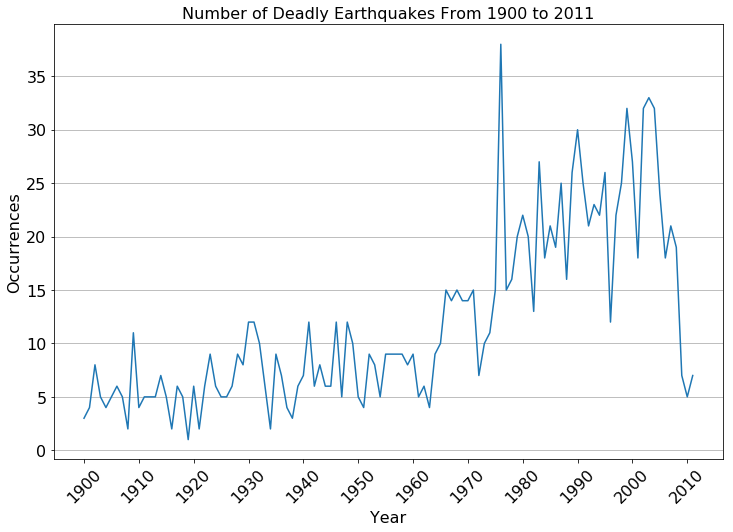

In [102]:
freq = eq_yearly['count']
plt.plot(freq)
dates = freq.index[::10]
labels = dates.strftime('%Y')
plt.xticks(dates, labels, rotation=45, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Number of Deadly Earthquakes From 1900 to 2011', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Occurrences', fontsize = 16);

## There appear to be more deadly earthquakes as time goes on

## Could be due to advancements in technology and reporting deaths

## Examine earthquakes by month to see if that yields anything interesting

In [36]:
# Creating a new dataframe with the number of deadly earthquakes each year
eq_monthly = eq_date_ind['country'].resample('M').agg('count')
eq_monthly = pd.DataFrame(eq_monthly)
eq_monthly.columns = ['count']
eq_monthly = eq_monthly.reset_index()
eq_monthly['count'] = pd.to_numeric(eq_monthly['count'])
eq_monthly['origin'] = eq_monthly['origin'].map(lambda x: x.month)
eq_monthly.head()

,origin,count
0,5,1
1,6,0
2,7,1
3,8,0
4,9,0


In [37]:
eq_month_total = eq_monthly.groupby('origin').sum()
#month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
eq_month_total = eq_month_total.reset_index()
eq_month_total = eq_month_total.sort_values(by = 'count', ascending = False)
#eq_month_total['origin'] = month_list
eq_month_total

,origin,count
2,3,131
4,5,122
6,7,117
3,4,116
1,2,115
7,8,111
10,11,107
5,6,106
8,9,106
11,12,106


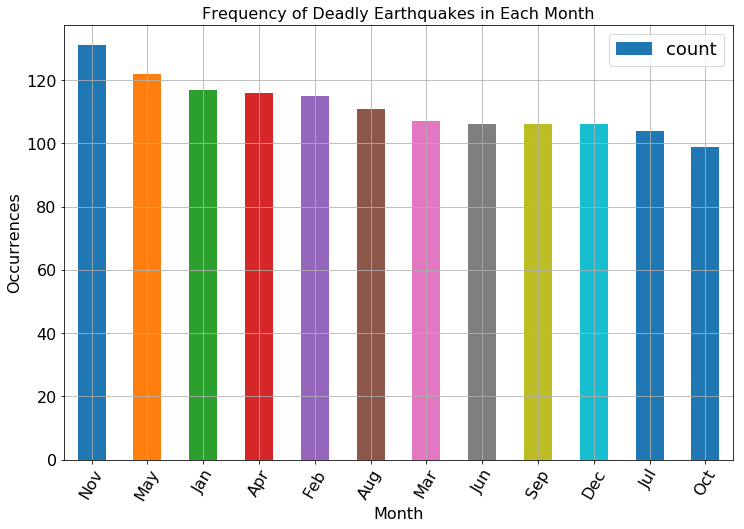

In [103]:
eq_month_total.plot(kind = 'bar', x = 'origin', y = 'count')
month_ticks = eq_month_total.index.values
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_ticks, month_list, rotation=60, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Frequency of Deadly Earthquakes in Each Month', fontsize = 16)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('Occurrences', fontsize = 16);

## The earthquakes seem to be pretty evenly distributed over the months of the year

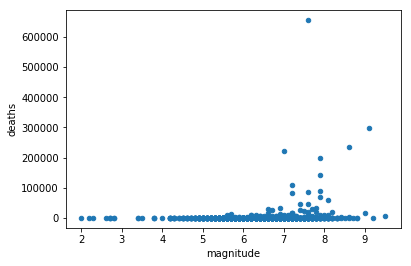

In [39]:
clean_df.plot(kind = 'scatter', x = 'magnitude', y = 'deaths')

In [40]:
countries = gpd.read_file('./Data/country_borders.geojson')
countries.head(1)

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((61.21081709172574 35.65007233330923,..."


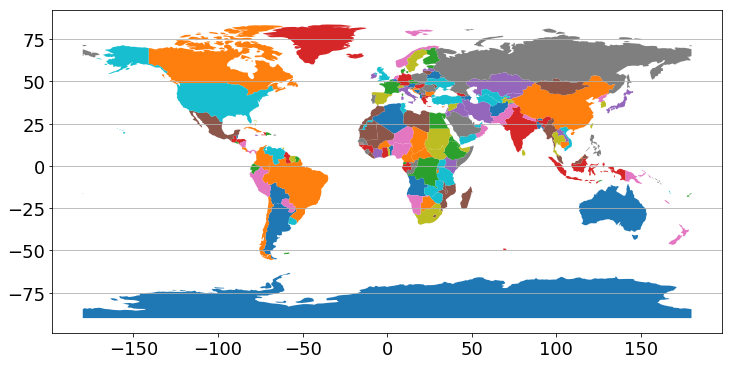

In [104]:
countries.plot(column = 'admin')

In [105]:
plate_bounds = gpd.read_file('./Data/tectonic_boundaries.geojson')
plate_bounds.head(1)

,cartodb_id,type,plateb,platea,source,name,layer,geometry
0,4,,AN,SO,Lemaux et al. [2002],SO-AN,plate boundary,"(LINESTRING (32.1258 -46.9998, 33.1739 -47.264..."


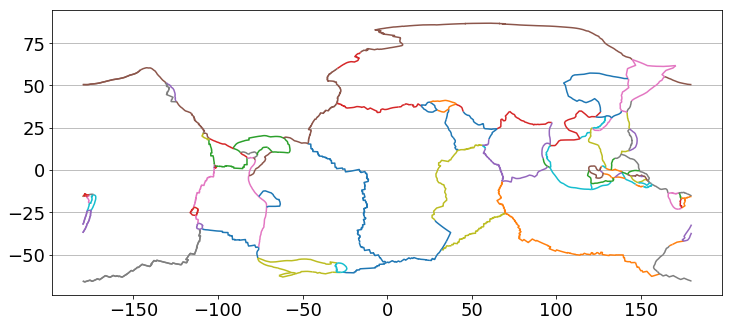

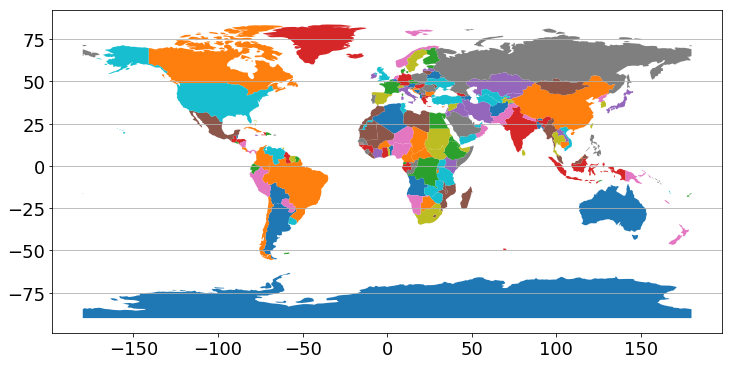

In [106]:
plate_bounds.plot(column = 'name')
countries.plot(column = 'admin')

In [44]:
# Creating a DF to map the points
# Dropping the rows with NaN for Lat and Long
map_df = clean_df.dropna(subset=['lat'])
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1339
Data columns (total 14 columns):
origin               1325 non-null datetime64[ns]
country              1325 non-null object
lat                  1325 non-null float64
long                 1325 non-null float64
depth_km             1248 non-null object
magnitude            1324 non-null float64
secondary_effects    370 non-null object
pde_shaking          739 non-null float64
pde_total            749 non-null float64
utsu_total           1027 non-null float64
em_dat_total         559 non-null float64
other_source         27 non-null float64
deaths               1262 non-null float64
geometry             1325 non-null object
dtypes: datetime64[ns](1), float64(9), object(4)
memory usage: 155.3+ KB


In [45]:
# GeoDataFrame of Clean DF
clean_geo = gpd.GeoDataFrame(map_df, crs = plate_bounds.crs, geometry = clean_df['geometry'])

In [46]:
# for row in clean_df.iterrows():
#     row_values = row[1]
#     print(row_values)

In [170]:
#create our map of the world and show it
map_world = folium.Map(location = [0,0], zoom_start = 2)

#draw our plate boundaries: plate_bounds
folium.GeoJson(plate_bounds).add_to(map_world)

#iterate through our urban art to create locations and markers for each piece
#here lat is listed first!!
#also the apostrophe in the 4th row causes problems!

for row in map_df.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['long']]
    popup = 'Date: ' + str(row_values['origin']) + '<br/>' +  'Country: ' + str(row_values['country']) + '<br/>' + 'Magnitude: ' + str(row_values['magnitude'])+ '<br/>'+ 'Deaths: ' + str(row_values['deaths'])
    mag_radius = 4.6 ** row_values['magnitude'] 
    #mag_radius = row_values['magnitude'] ** 6.2
    death_radius = row_values['deaths']  * 5
    #marker = folium.Marker(location = location, popup = popup)
    if row_values['magnitude'] > 5.5:
        marker = folium.Circle(location=location, popup=popup, radius=mag_radius, color='crimson', fill=False, fill_color='crimson').add_to(map_world)
        marker.add_to(map_world)
    if row_values['deaths'] > 8000:
        marker = folium.Circle(location=location, popup=popup, radius=death_radius, color='green', fill=False, fill_color='green').add_to(map_world)
        marker.add_to(map_world)

# Show map
map_world

In [48]:
map_hooray = folium.Map(location=[0, 0], zoom_start = 2) 
#draw our plate boundaries: plate_bounds
folium.GeoJson(plate_bounds).add_to(map_hooray)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = map_df[map_df['magnitude']>= 5.5] # Reducing data size so it runs faster
heat_df = heat_df[['lat', 'long']]
#heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['long']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# Display the map
map_hooray

In [49]:
#clean_df.sort_values(by='depth_km', ascending = True).head(20)

In [50]:
above_9 = clean_df.loc[clean_df['magnitude']>=9]
above_9.head(10)

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths,geometry
332,1952-11-04 16:58:00,Russian Federation,52.755,160.057,22.2,9.0,T,NaN,NaN,NaN,NaN,NaN,NaN,POINT (160.057 52.755)
396,1960-05-22 19:11:00,Chile,-38.235,-73.047,35,9.5,T,NaN,NaN,5700.0,6000.0,NaN,6000.0,POINT (-73.047 -38.235)
416,1964-03-28 03:36:00,United States,61.017,-147.648,6.6,9.2,T,NaN,NaN,131.0,131.0,NaN,131.0,POINT (-147.648 61.017)
1238,2004-12-26 00:58:00,Indonesia,3.287,95.972,30,9.1,"T,L",NaN,297200.0,NaN,NaN,231000.0,297200.0,POINT (95.97200000000001 3.287)
1335,2011-03-11 14:46:00,Japan,38.322,142.369,24.4,9.0,T,NaN,NaN,NaN,NaN,15894.0,15894.0,POINT (142.369 38.322)


## Only 5 deadly earthquakes magnitude 9 or above between 1900 and 2011

In [51]:
between_8_9 = clean_df.loc[clean_df['magnitude']>=8]
between_8_9 = between_8_9.loc[between_8_9['magnitude']<9]
between_8_9.shape

(46, 14)

In [52]:
# Grouping by country and counting to see the countries which have the most earthquakes
maj_count = between_8_9[['country', 'origin']].groupby(by = 'country').agg('count').sort_values(by ='origin', ascending = False)
maj_count = maj_count.reset_index()
maj_count.columns = ['country', 'count']
maj_count.head(10)

,country,count
0,Japan,7
1,Indonesia,6
2,Chile,5
3,Peru,4
4,Philippines,4
5,Russian Federation,3
6,China,2
7,Colombia,2
8,Mexico,2
9,Pakistan,2


In [53]:
maj_count['years_per_quake'] = 111/maj_count['count']
maj_count.head(10)

,country,count,years_per_quake
0,Japan,7,15.857143
1,Indonesia,6,18.500000
2,Chile,5,22.200000
3,Peru,4,27.750000
4,Philippines,4,27.750000
5,Russian Federation,3,37.000000
6,China,2,55.500000
7,Colombia,2,55.500000
8,Mexico,2,55.500000
9,Pakistan,2,55.500000


# USGS gives the following descriptions for magnitude ranges:
<br>

<font size=5px>
**5.0-5.9**: Moderate <br>
**6.0-6.9**: Strong <br>
**7.0-7.9**: Major <br>
**8.0 and higher**: Great
</font>


In [54]:
between_8_9.head()

,origin,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking,pde_total,utsu_total,em_dat_total,other_source,deaths,geometry
18,1903-08-11 04:32:00,Greece,36.360,22.970,80,8.3,NaN,NaN,NaN,2.0,NaN,NaN,2.0,POINT (22.97 36.36)
29,1906-01-31 15:36:00,Ecuador,1.000,-81.500,0,8.8,T,NaN,NaN,1000.0,400.0,NaN,1000.0,POINT (-81.5 1)
33,1906-08-17 00:40:00,Chile,-33.000,-72.000,0,8.2,T,NaN,NaN,3760.0,20000.0,NaN,20000.0,POINT (-72 -33)
61,1911-06-15 14:26:00,Japan,28.000,130.000,90,8.1,T,NaN,NaN,12.0,NaN,NaN,12.0,POINT (130 28)
94,1918-08-15 12:18:00,Philippines,5.653,123.563,35,8.2,NaN,NaN,NaN,NaN,100.0,NaN,100.0,POINT (123.563 5.653)


In [55]:
# Aggregate by count and average time difference
time_diff_8_9 = between_8_9.groupby('country').origin.agg({'count': 'count', 'avg_time_diff': lambda x: x.sort_values().diff().mean()})
time_diff_8_9 = time_diff_8_9.reset_index()



/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [56]:
time_diff_8_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
country          18 non-null object
count            18 non-null int64
avg_time_diff    11 non-null timedelta64[ns]
dtypes: int64(1), object(1), timedelta64[ns](1)
memory usage: 512.0+ bytes


In [57]:
time_diff_8_9['years'] = (time_diff_8_9.avg_time_diff.dt.days / 365).round(2)

time_diff_8_9.sort_values(by='years').head(15)

,country,count,avg_time_diff,years
3,Colombia,2,3420 days 14:51:00,9.37
8,Mexico,2,3672 days 02:18:00,10.06
11,Pakistan,2,3834 days 00:24:00,10.50
13,Peru,4,4970 days 16:39:40,13.62
6,Indonesia,6,5502 days 18:47:48,15.07
7,Japan,7,5617 days 12:54:00,15.39
14,Philippines,4,7062 days 01:17:40,19.35
1,Chile,5,9453 days 19:28:30,25.90
12,Papua New Guinea,2,10717 days 22:43:00,29.36
2,China,2,10834 days 02:04:00,29.68


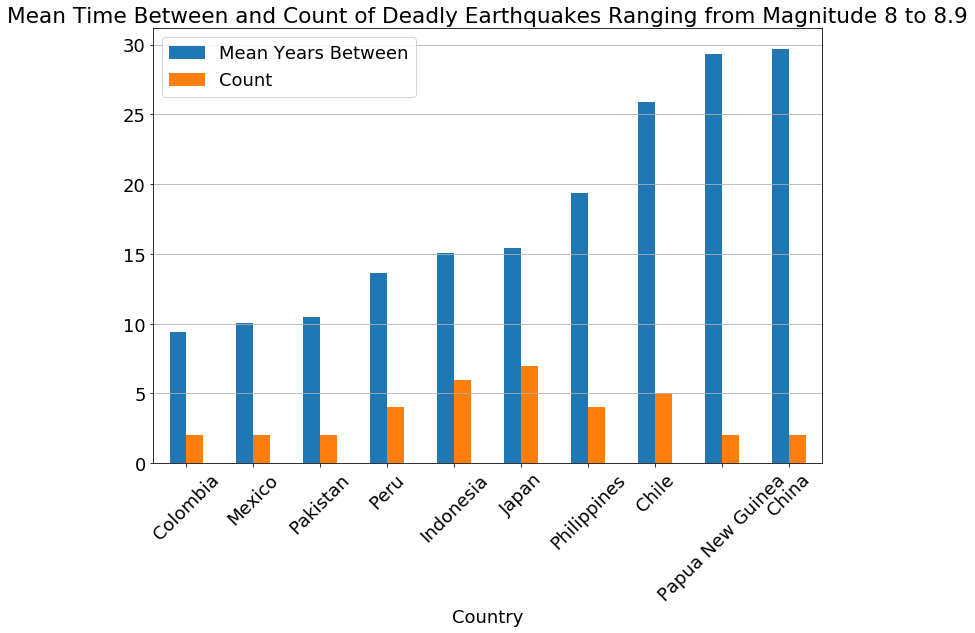

In [101]:
time_diff_8_9.sort_values(by='years', ascending=True).head(10).plot(kind='bar', y=['years','count'], x='country', legend=True)
plt.grid(axis='x')
plt.legend(['Mean Years Between', 'Count'])
plt.title('Mean Time Between and Count of Deadly Earthquakes Ranging from Magnitude 8 to 8.9')
plt.xlabel('Country')
#plt.ylabel('Mean Time Between Earthquakes (Years)')
plt.xticks(rotation=45);

## Colombia had the shortest amount of time on average between great earthquakes, but they only had two of them. They were unfortunate that they happened relatively close together

## We have to go to Peru to find a little bit better sample size. They had 4 such earthquakes and they occurred roughly every 14 years

In [58]:
between_7_8 = clean_df.loc[clean_df['magnitude']>=7]
between_7_8 = between_7_8.loc[between_7_8['magnitude']<8]
between_7_8.shape

(342, 14)

In [59]:
# Aggregate by count and average time difference
time_diff_7_8 = between_7_8.groupby('country').origin.agg({'count': 'count', 'avg_time_diff': lambda x: x.sort_values().diff().mean()})
time_diff_7_8 = time_diff_7_8.reset_index()

/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [60]:
time_diff_7_8['years'] = (time_diff_7_8.avg_time_diff.dt.days / 365).round(2)

time_diff_7_8.sort_values(by='years', ascending=True).head(20)

,country,count,avg_time_diff,years
6,Chile,27,1109 days 03:12:50.769230,3.04
20,Indonesia,34,1137 days 03:03:32.727272,3.12
23,Japan,34,1227 days 12:16:38.181818,3.36
7,China,32,1245 days 15:35:44.516129,3.41
27,Mexico,28,1295 days 14:04:22.222222,3.55
34,Peru,19,1869 days 14:52:16.666666,5.12
35,Philippines,19,1984 days 14:11:20,5.44
43,Taiwan,19,2043 days 10:17:06.666666,5.60
46,Turkey,16,2639 days 16:42:44,7.23
9,Costa Rica,2,2941 days 19:06:00,8.06


## Plotting the Top 10 countries with the shortest time between major earthquakes

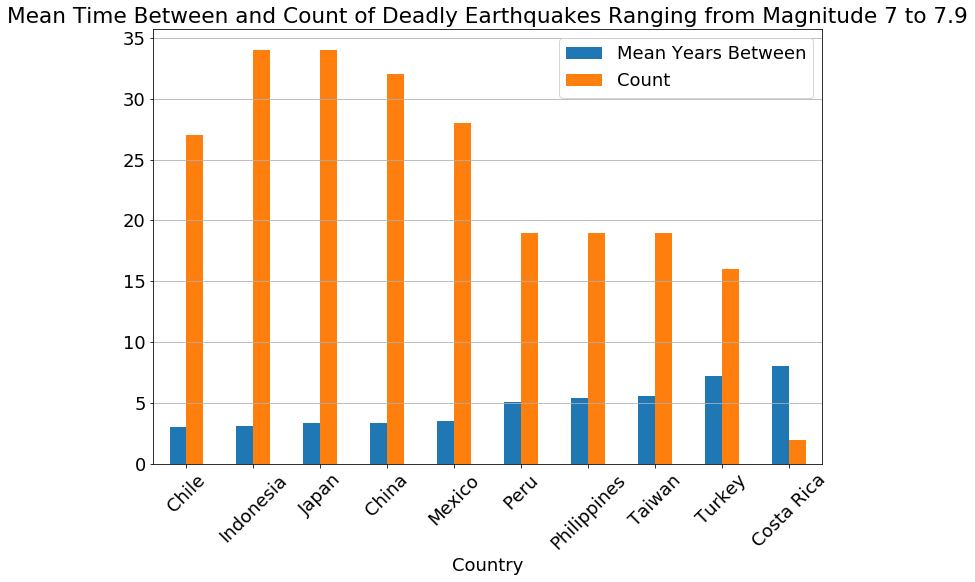

In [100]:
time_diff_7_8.sort_values(by='years', ascending=True).head(10).plot(kind='bar', y=['years','count'], x='country', legend=True)
plt.grid(axis='x')
plt.legend(['Mean Years Between', 'Count'])
plt.title('Mean Time Between and Count of Deadly Earthquakes Ranging from Magnitude 7 to 7.9')
plt.xlabel('Country')
#plt.ylabel('Mean Time Between Earthquakes (Years)')
plt.xticks(rotation=45);

# Chile had the shortest amount of time between major earthquakes, although it didn't have the highest number of such quakes
# That distinction belonged to Indonesia and Japan

In [61]:
between_6_7 = clean_df.loc[clean_df['magnitude']>=6]
between_6_7 = between_6_7.loc[between_6_7['magnitude']<7]
between_6_7.shape

(511, 14)

In [62]:
# Aggregate by count and average time difference
time_diff_6_7 = between_6_7.groupby('country').origin.agg({'count': 'count', 'avg_time_diff': lambda x: x.sort_values().diff().mean()})
time_diff_6_7 = time_diff_6_7.reset_index()

/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [63]:
# Converting the time delta values to Years
time_diff_6_7['years'] = (time_diff_6_7.avg_time_diff.dt.days / 365).round(2)

time_diff_6_7.sort_values(by='years', ascending=True).head(20)

,country,count,avg_time_diff,years
13,China,58,699 days 11:47:10.526315,1.92
1,Afghanistan,16,814 days 22:49:12,2.23
36,Indonesia,39,874 days 16:15:52.105263,2.39
37,Iran,43,891 days 11:59:55.714285,2.44
65,Turkey,34,1118 days 16:27:30.909090,3.06
40,Japan,33,1227 days 07:41:26.250000,3.36
30,Greece,28,1405 days 21:14:26.666666,3.85
32,Guatemala,7,1516 days 11:26:30,4.15
14,Colombia,10,1578 days 01:57:06.666666,4.32
62,Taiwan,22,1705 days 11:17:28.571428,4.67


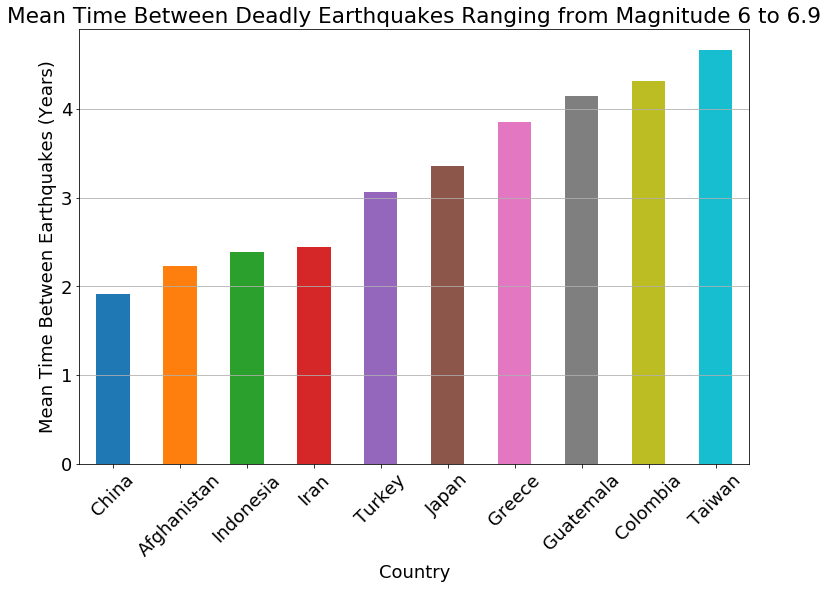

In [97]:
time_diff_6_7.sort_values(by='years', ascending=True).head(10).plot(kind='bar', y='years', x='country', legend=False)
plt.grid(axis='x')
plt.title('Mean Time Between Deadly Earthquakes Ranging from Magnitude 6 to 6.9')
plt.xlabel('Country')
plt.ylabel('Mean Time Between Earthquakes (Years)')
plt.xticks(rotation=45);

## China has the shortest time between strong earthquakes

### However China is a very large country, so there is a large area that will be unaffected by earthquakes

In [156]:
country_area_df = pd.read_csv('Data/area_sq_km.csv')
country_area_df = country_area_df.iloc[:,[0,-2]]
country_area_df.columns = ['country', 'area']
country_area_df.iloc[252, 0]= 'Venezuela'
country_area_df.iloc[110, 0]= 'Iran'
country_area_df.iloc[120, 0]= 'Kyrgyzstan'
country_area_df.head()

,country,area
0,Aruba,180.0
1,Afghanistan,652860.0
2,Angola,1246700.0
3,Albania,27400.0
4,Andorra,470.0


## Merge together and find number of deadly earthquakes per decade per 1,000,00 sq. km

In [157]:
merged_df = eq_count.merge(country_area_df, how='left', on='country')
# Adding in missing data
merged_df.iloc[6,2] = 36197 # Taiwan
merged_df.iloc[24,2] = 676578 # Burma (Myanmar)
merged_df.iloc[36,2] = 2345409 # Democratic Republic of the Congo
merged_df.head(10)

,country,count,area
0,China,166,9388211.0
1,Indonesia,96,1811570.0
2,Turkey,95,769630.0
3,Iran,91,1628760.0
4,Japan,82,364560.0
5,Peru,54,1280000.0
6,Taiwan,47,36197.0
7,Mexico,46,1943950.0
8,Chile,44,743532.0
9,Greece,44,128900.0


In [165]:
total_years = 111
decades = total_years / 10
area_unit = 1000000 # Earthquakes per 1,000,000 sq km
standard_df = merged_df
standard_df['earthquake_density'] = standard_df['count'] / total_years / (standard_df['area'] / area_unit)
standard_df.sort_values(by='earthquake_density', ascending=False).head(10)

#Number of earthquakes per year per 1,000,000 sq km (about the size of Ethiopia, a little bigger than Texas)
# or number of earthquakes per decade per 100,000 sq km (About the size of Kentucky)

,country,count,area,earthquake_density
6,Taiwan,47,36197.0,11.697749
78,Samoa,1,2830.0,3.183395
9,Greece,44,128900.0,3.075224
32,El Salvador,7,20720.0,3.043584
57,Cyprus,3,9240.0,2.925003
33,Albania,7,27400.0,2.301572
4,Japan,82,364560.0,2.026385
26,Costa Rica,10,51060.0,1.764397
58,Jamaica,2,10830.0,1.663714
65,Vanuatu,2,12190.0,1.478098


In [167]:
standard_df.sort_values(by='earthquake_density', ascending=True).head(10)
# Least earthquake dense countries

,country,count,area,earthquake_density
86,Brazil,1,8358140.0,0.001078
56,Canada,3,9093510.0,0.002972
52,Australia,3,7682300.0,0.003518
76,Sudan,1,2376000.0,0.003792
106,Mongolia,1,1553560.0,0.005799
22,Russian Federation,13,16376870.0,0.007151
108,Mozambique,1,786380.0,0.011456
47,Kazakhstan,4,2699700.0,0.013348
73,Spain,1,500210.0,0.018010
66,Ethiopia,2,1000000.0,0.018018


## It looks like Brazil is the least Earthquake dense country on this list, with only 1 such earthquake over the whole timeframe

# USGS Map of seismic hazards

<img src="https://earthquake.usgs.gov/hazards/learn/images/2014hazmap-induced-lg.gif">
<br>
## This map is provided by the USGS, but it gives an idea of places in America that experience the most seismic activity